In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn import pipeline, preprocessing
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, KFold
from sklearn import model_selection, metrics

#import models
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier, RandomTreesEmbedding
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
# from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

from df_transformers import SelectColumnsTransfomer

%matplotlib inline

In [2]:
train_data = pd.read_csv("data/preprocessed_train_data.csv", index_col="PassengerId")
test_data = pd.read_csv("data/preprocessed_test_data.csv", index_col="PassengerId")
print(f"Shape of train data: {train_data.shape}. Shape of test data: {test_data.shape}")

Shape of train data: (891, 53). Shape of test data: (418, 52)


### Разделяем выборку на трейн и тест

In [3]:
X = train_data.drop(['Survived'], axis=1)
y = train_data['Survived']
X.shape

(891, 52)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### Define a cross validation strategy

In [5]:
seed = 3
scoring = 'accuracy'
n_folds = 7

def accuracy_cv(model):
    kfold = KFold(n_splits=n_folds, random_state=seed)
    return cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=-1)

## Models

In [6]:
# источник - https://www.kaggle.com/kabure/eda-pipelines-v2-0-easy-to-begineers

clfs = []

clfs.append(("LogReg", 
             Pipeline([("Scaler", StandardScaler()),
                       ("LogReg", LogisticRegression())])))

# clfs.append(("XGBClassifier",
#              Pipeline([("Scaler", StandardScaler()),
#                        ("XGB", XGBClassifier())]))) 
clfs.append(("KNN", 
             Pipeline([("Scaler", StandardScaler()),
                       ("KNN", KNeighborsClassifier())]))) 

clfs.append(("DecisionTreeClassifier", 
             Pipeline([("Scaler", StandardScaler()),
                       ("DecisionTrees", DecisionTreeClassifier())]))) 

clfs.append(("RandomForestClassifier", 
             Pipeline([("Scaler", StandardScaler()),
                       ("RandomForest", RandomForestClassifier(n_estimators=100))]))) 

clfs.append(("GradientBoostingClassifier", 
             Pipeline([("Scaler", StandardScaler()),
                       ("GradientBoosting", GradientBoostingClassifier(n_estimators=100))]))) 

clfs.append(("RidgeClassifier", 
             Pipeline([("Scaler", StandardScaler()),
                       ("RidgeClassifier", RidgeClassifier())])))

clfs.append(("BaggingRidgeClassifier",
             Pipeline([("Scaler", StandardScaler()),
                       ("BaggingClassifier", BaggingClassifier())])))

clfs.append(("ExtraTreesClassifier",
             Pipeline([("Scaler", StandardScaler()),
                       ("ExtraTrees", ExtraTreesClassifier())])))

In [7]:
results, names  = [], [] 

for name, model  in clfs:
    cv_results = accuracy_cv(model)
    names.append(name)
    results.append(cv_results)    
    msg = "%s: %f (+/- %f)" % (name, cv_results.mean(),  cv_results.std())
    print(msg)

LogReg: 0.818620 (+/- 0.025073)
KNN: 0.812199 (+/- 0.031042)
DecisionTreeClassifier: 0.747994 (+/- 0.034426)
RandomForestClassifier: 0.786517 (+/- 0.028803)
GradientBoostingClassifier: 0.825040 (+/- 0.020681)
RidgeClassifier: 0.833066 (+/- 0.022813)
BaggingRidgeClassifier: 0.784912 (+/- 0.032581)
ExtraTreesClassifier: 0.780096 (+/- 0.035964)


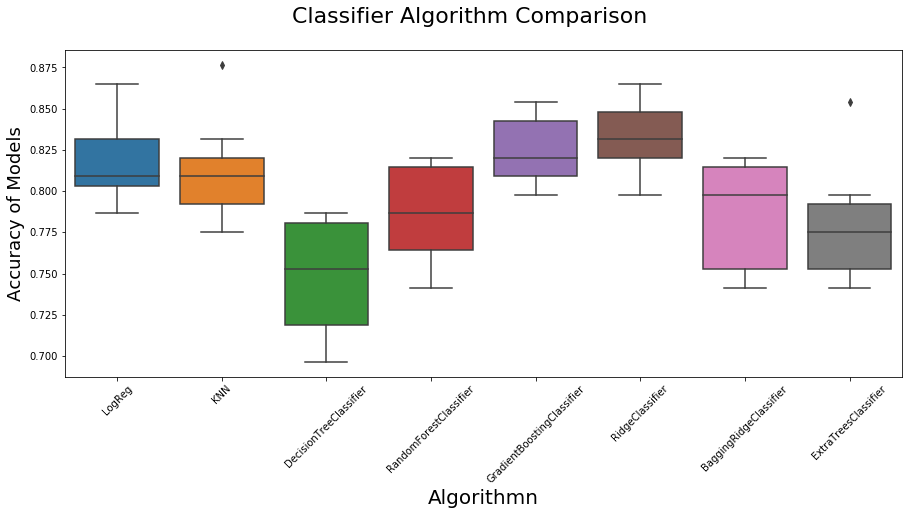

In [8]:
fig = plt.figure(figsize=(15,6))
fig.suptitle('Classifier Algorithm Comparison', fontsize=22)
ax = fig.add_subplot(111)
sns.boxplot(x=names, y=results)
ax.set_xticklabels(names)
ax.set_xlabel("Algorithmn", fontsize=20)
ax.set_ylabel("Accuracy of Models", fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

In [9]:
# Лучшее значение дает GradientBoostingClassifier
gbc = Pipeline([("Scaler", StandardScaler()),
                       ("GradientBoosting", GradientBoostingClassifier(n_estimators=100))])
gbc.fit(X_train, y_train)
predictions = gbc.predict(X_test)
print(metrics.accuracy_score(y_test, predictions))

0.835820895522388


last result 0.835820895522388

## Test data submission

In [10]:
test_data.shape

(418, 52)

In [11]:
gbc.fit(X, y)
predicted = gbc.predict(test_data)
test_data["Survived"] = predicted
test_data["Survived"].to_csv('gbc.csv', header=True)

In [12]:
test_data["Survived"].head()

PassengerId
892    0
893    0
894    0
895    0
896    1
Name: Survived, dtype: int64